* [x] ignore illegal action
* [x] penalize revisiting states
* [x] penalize too many steps
* [x] net use cov, output depends on input
* agent: 

* * [ ] [DQN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
* * [ ] [Double DQN](https://arxiv.org/abs/1509.06461)
* * [ ] [PER](https://arxiv.org/abs/1511.05952)

* * [ ] [A3C/A2C](https://arxiv.org/abs/1602.01783)
* * [ ] [PPO](https://arxiv.org/abs/1707.06347)
* * [ ] [SAC](https://arxiv.org/abs/1801.01290)
* * [ ] [DPG](http://proceedings.mlr.press/v32/silver14.pdf)/[DDPG](https://arxiv.org/abs/1509.02971)

* loss? measure performance? optimal path? 
* train with sizes X, test on sizes Y
------------------------------
* https://github.com/Taospirit/DRL-with-pytorch
* https://lilianweng.github.io/posts/2018-02-19-rl-overview
* https://spinningup.openai.com/en/latest/spinningup/keypapers.html

* https://boring-guy.sh/posts/masking-rl/
* https://datascience.stackexchange.com/questions/61536/deep-reinforcement-learning-on-changing-data-sizes
* https://stats.stackexchange.com/questions/270618/why-does-q-learning-use-epsilon-greedy-during-testing
------------------------------

* loss is much more well-behaved after embedding!
* only 6 playable config with 342.. how to make model generalize better?
* how to penalize loops?
* how to find optimal steps?
* reward enjineering is very important!!!

before implementing the others, I want to make sure the current code for DQN and REINFORCE are accurate enough :(

EVALUATION MATRIX BOARD SIZE, VALUE INSIDE IS ACCUARCY!!

In [1]:
import random
import copy
from typing import List, Tuple
import enum
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import gym
from gym import spaces

from data import data as og_data

In [2]:
# import ast
# from config_cp import solvable as s1
# from config3 import solvable as s2
# from config4 import solvable as s3
# from config2_cp import solvable
# # with open("config4.py", "r+") as f:
# #     data = f.read()
# #     data = data.replace("(", "'(").replace(")", ")'")
# #     f.seek(0)
# #     f.truncate()
# #     f.write(data)

# solvable.update(s1)
# solvable.update(s2)
# solvable.update(s3)

# print(len(solvable), sum([len(v) for v in solvable.values()]))

# solvable = dict((ast.literal_eval(str(old_key)), list(value)) for (old_key, value) in solvable.items())
# for k, v in solvable.items():
#     solvable[k] = [ast.literal_eval(x) for x in solvable[k]]

# print(len(solvable), sum([len(v) for v in solvable.values()]))

# # with open("data.py", "w") as f:
# #     f.write("data=" + str(solvable))

In [3]:
class Phase(enum.Enum):
    TRAINING = TRAIN = enum.auto()
    VALIDATION = VALID = VAL = enum.auto()
    TESTING = TEST = enum.auto()

In [173]:
class Board:
    def __init__(self, num_color: int, max_length: int, empty: int = 2):
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty
        self.flasks = np.full((self.tubes, self.max_length), -1, dtype=np.int16)

        self.idx = np.zeros(self.tubes, dtype=np.uint16)
        self.idx[:self.num_color] = self.max_length

        self.actions = []
        self.states = set()

    def __str__(self):
        return str(self.flasks) # [np.argsort(self.flasks[:, 0])])

    def __repr__(self):
        return str(self.flasks)

    def __iter__(self):
        return iter(self.flasks)

    def __len__(self):
        return len(self.flasks)

    def __getitem__(self, item):
        return self.flasks[item]

    def grid_to_state(self) -> List[List[int]]:
        state = []
        for r in self:
            state.append([])
            for c in r:
                if c != -1:
                    state[-1].append(c)
        return state

    def state_to_grid(self, state: List[List[int]]):
        self.flasks.fill(-1)
        self.idx.fill(0)
        self.actions = []
        self.states = set()
        for i, r in enumerate(state):
            self.idx[i] = len(r)
            for j, c in enumerate(r):
                self.flasks[i][j] = c

    def is_flask_full(self, i: int) -> bool:
        return self.idx[i] == self.max_length

    def is_flask_empty(self, i: int) -> bool:
        return self.idx[i] == 0

    def has_one_color(self, i: int) -> bool:
        if self.idx[i] == 0:
            return True
        return (self.flasks[i][:self.idx[i]] == self.flasks[i][0]).all()

    def is_flask_solved(self, i: int) -> bool:
        if self.is_flask_empty(i) or (self.is_flask_full(i) and self.has_one_color(i)):
            return True
        return False

    def top(self, i: int) -> int:
        return self.flasks[i][self.idx[i]-1]

    def pop(self, i: int) -> int:
        ball = self.flasks[i][self.idx[i]-1]
        self.flasks[i][self.idx[i] - 1] = -1
        self.idx[i] -= 1
        return ball

    def push(self, i: int, ball: int):
        self.flasks[i][self.idx[i]] = ball
        self.idx[i] += 1

    def is_push_allowed(self, i: int, ball: int) -> bool:
        if self.is_flask_empty(i) or (self.top(i) == ball and not self.is_flask_full(i)):
            return True
        return False

    def is_invalid_init_state(self) -> bool:
        return any(self.is_flask_full(i) and self.has_one_color(i) for i in range(self.tubes))

    def is_solved(self) -> bool:
        return all(self.is_flask_solved(i) for i in range(self.tubes))

    def valid_actions(self) -> List[Tuple[int, int]]:
        actions = []
        for i in range(self.tubes):
            if self.is_flask_solved(i):
                continue
            if self.is_flask_empty(i):
                continue
            top_i = self.top(i)
            for j in range(self.tubes):
                if i != j and self.is_push_allowed(j, top_i):
                    actions.append((i, j))
        return actions

    def play(self, action: Tuple[int, int]):
        self.push(action[1], self.pop(action[0]))
        self.actions.append(action)

    def undo_action(self):
        action = self.actions.pop()
        self.push(action[0], self.pop(action[1]))

    def reward(self) -> int:
        factor = 10
        if self.is_solved():
            return 10
        if str(self) in self.states:
            return -1
        return 0

    def dfs_solve(self, steps: int = 0, path: List["Board"] = []) -> Tuple[bool, int, List["Board"]]:
        if self.is_solved():
            return True, steps, path
        if steps >= 1000:
            return False, steps, path
        for a in self.valid_actions():
            self.play(a)
            current_state = str(self)
            if current_state in self.states:
                self.undo_action()
                continue
            self.states.add(current_state)
            path.append(copy.deepcopy(self))
            r = self.dfs_solve(steps+1)
            if r[0]:
                return r
            self.undo_action()
        return False, steps, path

In [177]:
class BallSort(gym.Env):

    metadata = {"render_modes": ["human", "silent", "cli"]}

    cmap = colors.ListedColormap(['#000000', '#e4572e', '#1b998b', '#29335c', '#f3a712', '#669bbc', '#ed217c', '#58355e', '#f39c6b', '#ca907e', '#aeb7b3', '#c0b9dd', '#a8c686'])

    def __init__(self, train_data, validate_data, test_data, max_color, max_length, max_empty):
        super(BallSort, self).__init__()
        self.env_name = 'ball-sort-puzzle'
        # data
        self.data = {
            Phase.TRAINING: train_data,
            Phase.VALIDATION: validate_data,
            Phase.TESTING: test_data
        }
        # max configurations
        self.max_color = max_color
        self.max_length = max_length
        self.max_empty = max_empty
        self.max_tubes = self.max_color + self.max_empty
        # env action and state spaces
        self.action_space = spaces.Box(low=0, high=self.max_tubes - 1, shape=(2,), dtype=int)
        self.observation_space = spaces.Box(low=-1, high=self.max_color-1, shape=(self.max_tubes, self.max_length), dtype=int)

    def reset(self, phase, i=None):
        super().reset()
        self.steps = 0
        self.reward = 0
        self.solved = False

        # C, L, E, board, steps
        if i is None:
            sample = random.choice(self.data[phase])
        else:
            sample = self.data[phase][i]

        self.color = sample[0]
        self.length = sample[1]
        self.empty = sample[2]
        self.tubes = self.color + self.empty

        self.board = Board(*sample[:3])
        self.board.state_to_grid(sample[3])

        self.render()
        return self.board.flasks, sample[4]

    def step(self, action: Tuple[int, int]):
        # assert action in self.board.valid_actions(), "action must be playable!!"
        if action not in self.board.valid_actions():
            # print("action must be playable!!")
            self.steps += 1
            self.reward = -10
            self.solved = False
            self.render()
            return self.board.flasks, self.reward, self.solved, {"steps": self.steps, "done": True}

        self.board.play(action)
        self.steps += 1
        self.reward = self.board.reward()
        self.solved = self.board.is_solved()
        self.board.states.add(str(self.board))
        self.render()

        return self.board.flasks, self.reward, self.solved, {"steps": self.steps, "done": self.solved}

    def render(self):
        if self.render_mode == "cli":
            print("====================================================")
            print("Step:", self.steps)
            print(self.board.grid_to_state())
            print("State Reward:", self.reward)
            print("Is solved:", self.solved)
            print("====================================================")
        elif self.render_mode == "human":
            # plt.figure(figsize=(self.tubes, self.max_length))
            plt.imshow(self.board.flasks.T[::-1], cmap=self.cmap)
            plt.title(f"Step: {self.steps}. Reward: {self.reward}. Solved: {self.solved}")
            plt.axis("off")
            plt.show()

In [81]:
class Model(nn.Module):
    def __init__(self, max_color, max_length, max_empty, p=0.2, is_prob=False):
        super().__init__()
        self.max_tubes = max_color + max_empty
        self.max_length = max_length
        self.max_color = max_color
        self.max_empty = max_empty

        # max 12 balls + 1 for empty + 1 for badding
        self.em = nn.Embedding(num_embeddings=max_color+2, embedding_dim=3, padding_idx=0)

        # self.cnn = [nn.Conv2d(3, 8, (3, 1)), nn.Conv2d(8, 16, (3, 1)), nn.Conv2d(16, 32, (3, 3))]
        # self.bn = [nn.BatchNorm2d(8), nn.BatchNorm2d(16), nn.BatchNorm2d(32)]
        # self.drop = nn.Dropout(p=p)
        # self.mp = nn.MaxPool2d(2)
        self.flat = nn.Flatten()

        self.fc = [nn.Linear(3 * self.max_tubes * self.max_length, 256), nn.Linear(256, 256)]
        self.out = nn.Linear(256, (self.max_tubes) ** 2)
        self.is_prob = is_prob

    def forward(self, x, mask=None):
        # print(x.size())
        x = self.em(x)
        # print(x.size())
        x = x.permute(0, 3, 1, 2)
        # print(x.size())

#         for i in range(len(self.cnn)):
#             x = self.cnn[i](x)
#             x = self.bn[i](x)
#             x = F.relu(x)
#             print(x.size())
#             x = self.mp(x)
#             x = self.drop(x)
#             print(x.size())

        x = self.flat(x)
        # print(x.size())
        for i in range(len(self.fc)):
            x = self.fc[i](x)
            x = F.relu(x)
            # print(x.size())
        x = self.out(x)
        # print(x.size())

        if mask is not None:
            x[mask] = -np.inf
        if self.is_prob:
            x = F.softmax(x, dim=1)
        return x

In [82]:
class Agent:
    def __init__(self, env, max_color, max_length, max_empty, epsilon, gamma, lr, device):

        self.device = device
        # env set up
        self.max_color = max_color
        self.max_length = max_length
        self.max_empty = max_empty
        self.max_tubes = self.max_color + self.max_empty
        self.num_actions = self.max_tubes * self.max_tubes
        self.num_states = self.max_tubes * self.max_length

        self.env = env

        # reinforcement learning
        self.epsilon = epsilon
        self.gamma = gamma

        # neural network
        self.lr = lr

    def get_mask(self):
        allowed_actions = self.env.board.valid_actions()

        allowed_actions_linear = [i * self.max_tubes + j for i, j in allowed_actions]
        mask = torch.ones(self.num_actions, dtype=bool).to(self.device)
        mask[allowed_actions_linear] = False
        return mask

    def pad_state(self, state):
        num_tubes, length = state.shape
        return F.pad(state + 2, (0, self.max_length-length, 0, self.max_tubes-num_tubes), "constant", 0)

    def choose_action(self, state):
        return

    def learn(self):
        return

    def train(self, episodes=500, max_steps=None, plot=False):
        return

    def save(self, **kwargs):
        return

    def load(self, **kwargs):
        return

    def eval_one(self, phase, max_steps=None, i=None, render=False):
        if max_steps is not None:
            loop_range = range(max_steps)
        if render:
            self.env.render_mode = "human"
        state, dfs_steps = self.env.reset(phase, i=i)

        states = []
        self.eval_net.eval()
        self.epsilon = 0.05

        with torch.no_grad():
            ep_reward = 0
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                states.append(copy.deepcopy(state))

                state = self.pad_state(torch.LongTensor(state).to(self.device))
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)

                ep_reward += reward
                state = next_state

                if done:
                    break
            states.append(state)
        self.env.render_mode = "silent"
        return {"states": states, "done": done, "ep_reward": ep_reward, "steps": info["steps"], "dfs_steps": dfs_steps}

    def evaluate(self, phase, episodes=None, max_steps=None):
        if max_steps is not None:
            loop_range = range(max_steps)
        self.eval_net.eval()
        self.epsilon = 0.05
        reward_list = []
        step_list = []
        board_config_wins = {}
        if episodes is None:
            episodes = len(self.env.data[phase])
        for i in tqdm(range(1, episodes+1)):
            state, dfs_steps = self.env.reset(phase, i=i-1)
            state = self.pad_state(torch.LongTensor(state).to(self.device))

            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1

            ep_reward = 0
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))

                ep_reward += reward
                state = next_state
                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    break

            step_list.append(info['steps'])
            reward_list.append(ep_reward)
        return {"reward_list": reward_list, "step_list": step_list, "board_config_wins": board_config_wins}

In [115]:
class RandomAgent(Agent):
    def __init__(self, env, max_color, max_length, max_empty, epsilon, gamma, lr, device):
        super().__init__(env, max_color, max_length, max_empty, epsilon, gamma, lr, device)

    def choose_action(self, state):
        allowed_actions = self.env.board.valid_actions()
        if not allowed_actions:
            return (0, 0)
        return random.choice(allowed_actions)
        # action = random.randint(0, self.num_actions-1)
        # i = action // (self.max_tubes)
        # j = action % (self.max_tubes)
        # action = (i, j)
        # return action

    def train(self, episodes=300, max_steps=None, plot=False):
        if max_steps is not None:
            loop_range = range(max_steps)

        print("Collecting Experience....")
        reward_list = []
        step_list = []
        dfs_step_list = []
        board_config_wins = {}
        train_accuracy = []
        # episodes = len(self.env.train_data)
        total_wins = 0
        total_games = 0
        for i in (pbar := tqdm(range(1, episodes+1))):
            state, dfs_steps = self.env.reset(Phase.TRAINING)
            state = self.pad_state(torch.LongTensor(state).to(self.device))
            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1
            total_games += 1
            ep_reward = 0
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                ep_reward += reward
                if info["done"] != done:
                    break
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))
                state = next_state
                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    total_wins += 1
                    break

            dfs_step_list.append(dfs_steps)
            step_list.append(info['steps'])
            reward_list.append(ep_reward)
            train_accuracy.append(round(total_wins/total_games*100, 2))
            pbar.set_postfix_str(f"Game: {i}, {self.env.tubes}X{self.env.length}, {'won' if done else 'lost'}, steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, Win: {train_accuracy[-1]}%")
            if plot and ((i) % 50 == 0 or i == episodes):
                fig, ax = plt.subplots(3)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(step_list, 'g-', label='total_steps')
                ax[1].legend(loc="upper left")
                ax[2].plot(train_accuracy, 'g-', label='winning rate')
                ax[2].legend(loc="upper left")
                plt.show()

        return {"reward_list": reward_list, "step_list": step_list, "dfs_step_list": dfs_step_list, "board_config_wins": board_config_wins}

    def eval_one(self, phase, max_steps=None, i=None, render=False):
        if max_steps is not None:
            loop_range = range(max_steps)

        if render:
            self.env.render_mode = "human"
        state, dfs_steps = self.env.reset(phase, i=i)

        states = []

        with torch.no_grad():
            ep_reward = 0
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                states.append(copy.deepcopy(state))

                state = self.pad_state(torch.LongTensor(state).to(self.device))
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)

                ep_reward += reward
                state = next_state

                if done:
                    break
            states.append(state)
        self.env.render_mode = "silent"
        return {"states": states, "done": done, "ep_reward": ep_reward, "steps": info["steps"], "dfs_steps": dfs_steps}

    def evaluate(self, phase, episodes=None, max_steps=None):
        if max_steps is not None:
            loop_range = range(max_steps)

        reward_list = []
        step_list = []
        board_config_wins = {}
        if episodes is None:
            episodes = len(self.env.data[phase])
        for i in tqdm(range(1, episodes+1)):
            state, dfs_steps = self.env.reset(phase, i=i-1)
            state = self.pad_state(torch.LongTensor(state).to(self.device))

            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1

            ep_reward = 0
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))

                ep_reward += reward
                state = next_state
                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    break

            step_list.append(info['steps'])
            reward_list.append(ep_reward)
        return {"reward_list": reward_list, "step_list": step_list, "board_config_wins": board_config_wins}

In [156]:
class DQNAgent(Agent):
    def __init__(self, env, max_color, max_length, max_empty, epsilon, gamma, lr, device, delta, batch_size, memory_capacity, q_network_iteration):
        super().__init__(env, max_color, max_length, max_empty, epsilon, gamma, lr, device)

        # buffer replay set up
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.q_network_iteration = q_network_iteration
        self.learn_step_counter = 0
        self.memory_counter = 0

        # state, action, reward, next state, mask
        # self.memory = np.zeros((self.memory_capacity, self.num_states * 2 + 2 + self.num_actions)) 
        self.memory = np.zeros((self.memory_capacity, self.num_states * 2 + 2)) 

        # neural network
        self.eval_net = Model(self.max_color, self.max_length, self.max_empty).to(self.device)
        self.target_net = Model(self.max_color, self.max_length, self.max_empty).to(self.device)
        self.target_net.load_state_dict(self.eval_net.state_dict())

        self.delta = delta
        self.criterion = torch.nn.HuberLoss(delta=self.delta).to(self.device)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)

    def save(self, train_metric=None, validation_metric=None, filename=""):
        best_state = {
            'eval_net': self.eval_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        if train_metric is not None:
            best_state['train_metrics'] = dqn_train_res["board_config_wins"]
        if validation_metric is not None:
            best_state['valid_metrics'] = dqn_val_res["board_config_wins"]
        torch.save(best_state, f'../models/dqn/model_{filename}.pt')

    def load(self, filename=""):
        best_state = torch.load(f'../models/dqn/model_{filename}.pt')

        self.eval_net.load_state_dict(best_state["eval_net"])
        self.target_net.load_state_dict(best_state["target_net"])
        self.optimizer.load_state_dict(best_state["optimizer"])
        return best_state.get('train_metrics'), best_state.get('valid_metrics')

    def choose_random_valid_action(self):
        allowed_actions = self.env.board.valid_actions()
        if not allowed_actions:
            return (0, 0)
        return random.choice(allowed_actions)

    def choose_random_action(self):
        action = random.randint(0, self.num_actions-1)
        i = action // (self.max_tubes)
        j = action % (self.max_tubes)
        action = (i, j)
        return action

    def choose_best_valid_action(self, state):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0), mask.unsqueeze(0))
            # action_probs[:, mask] = -np.inf
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.max_tubes)
            j = action % (self.max_tubes)
            action = (i, j)
            return action

    def choose_best_action(self, state):
        with torch.no_grad():
            action_probs = self.eval_net(state.unsqueeze(0))
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.max_tubes)
            j = action % (self.max_tubes)
            action = (i, j)
            return action

    def choose_action(self, state):
        if np.random.randn() < self.epsilon:
            return self.choose_random_valid_action()
        else:
            return self.choose_best_valid_action(state)

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state.view(-1).cpu().numpy(),
                                [action, reward],
                                # mask.view(-1).cpu().numpy(),
                                next_state.reshape(-1)))
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # update the parameters
        if self.learn_step_counter % self.q_network_iteration == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch from memory
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.LongTensor(batch_memory[:, :self.num_states]).view(self.batch_size, self.max_tubes, self.max_length).to(self.device)
        batch_action = torch.LongTensor(batch_memory[:, self.num_states:self.num_states+1]).to(self.device)
        batch_reward = torch.FloatTensor(batch_memory[:, self.num_states+1:self.num_states+2]).to(self.device)
        # batch_mask = torch.tensor(batch_memory[:, self.num_states+2:self.num_states+2+self.num_actions], dtype=torch.bool).to(self.device)
        batch_next_state = torch.LongTensor(batch_memory[:, -self.num_states:]).view(self.batch_size, self.max_tubes, self.max_length).to(self.device)

        # q_eval
        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1)

        loss = self.criterion(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, episodes=300, max_steps=None, plot=False):
        if max_steps is not None:
            loop_range = range(max_steps)
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []
        dfs_step_list = []
        board_config_wins = {}
        train_accuracy = []
        # episodes = len(self.env.train_data)
        total_wins = 0
        total_games = 0
        for i in (pbar := tqdm(range(1, episodes+1))):
            if i < episodes * 0.5:
                self.epsilon = 0.99
            else:
                self.epsilon = max(0.05, 0.9*(1-(i)/episodes))
            state, dfs_steps = self.env.reset(Phase.TRAINING)
            state = self.pad_state(torch.LongTensor(state).to(self.device))
            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1
            total_games += 1
            ep_reward = 0
            loss = []
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                ep_reward += reward
                if info["done"] != done:
                    break
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))
                self.store_transition(state, action[0] * self.max_tubes + action[1], reward, next_state)

                if self.memory_counter >= self.memory_capacity:
                    loss.append(self.learn())
                state = next_state

                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    total_wins += 1
                    break

            dfs_step_list.append(dfs_steps)
            step_list.append(info['steps'])
            reward_list.append(ep_reward)
            if len(loss) > 1:
                loss_list.append(np.mean(loss))
            train_accuracy.append(round(total_wins/total_games*100, 2))
            pbar.set_postfix_str(f"Game: {i}, {self.env.tubes}X{self.env.length}, {'won' if done else 'lost'}, steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {np.mean(loss) if loss else ''}, Win: {train_accuracy[-1]}%")
            if plot and ((i) % 50 == 0 or i == episodes):
                fig, ax = plt.subplots(4)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(step_list, 'g-', label='total_steps')
                ax[2].legend(loc="upper left")
                ax[3].plot(train_accuracy, 'g-', label='winning rate')
                ax[3].legend(loc="upper left")
                plt.show()

        return {"reward_list": reward_list, "step_list": step_list, "dfs_step_list": dfs_step_list, "loss_list": loss_list, "board_config_wins": board_config_wins}

In [105]:
class REINFORCEAgent(Agent):
    def __init__(self, env, max_color, max_length, max_empty, epsilon, gamma, lr, device):
        super().__init__(env, max_color, max_length, max_empty, epsilon, gamma, lr, device)

        # memory
        self.saved_log_probs = []
        self.rewards = []

        # neural network
        self.eval_net = Model(self.max_color, self.max_length, self.max_empty, is_prob=True).to(self.device)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)

    def save(self, train_metric=None, validation_metric=None, filename=""):
        best_state = {
            'eval_net': self.eval_net.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        if train_metric is not None:
            best_state['train_metrics'] = dqn_train_res["board_config_wins"]
        if validation_metric is not None:
            best_state['valid_metrics'] = dqn_val_res["board_config_wins"]
        torch.save(best_state, f'../models/reinforce/model_{filename}.pt')

    def load(self, filename=""):
        best_state = torch.load(f'../models/reinforce/model_{filename}.pt')

        self.eval_net.load_state_dict(best_state["eval_net"])
        self.optimizer.load_state_dict(best_state["optimizer"])
        return best_state.get('train_metrics'), best_state.get('valid_metrics')

    def choose_action(self, state, phase=Phase.TRAINING):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0), mask.unsqueeze(0))
            try:
                m = Categorical(action_probs)
                action = m.sample()
                if phase == Phase.TRAINING:
                    self.saved_log_probs.append(m.log_prob(action))
                action = action.item()
                i = action // (self.max_tubes)
                j = action % (self.max_tubes)
                action = (i, j)
                return action
            except ValueError:
                return (0, 0)

    def learn(self):
        R = 0
        policy_loss = []
        rewards = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards, requires_grad=True)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.epsilon)
        for log_prob, reward in zip(self.saved_log_probs, rewards):
            policy_loss.append(-log_prob * reward)

        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        self.saved_log_probs = []
        self.rewards = []

        return policy_loss.item()

    def train(self, episodes=300, max_steps=None, plot=False):
        if max_steps is not None:
            loop_range = range(max_steps)
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []
        dfs_step_list = []
        train_accuracy = []
        board_config_wins = {}
        total_wins = 0
        total_games = 0
        for i in (pbar := tqdm(range(1, episodes+1))):
            state, dfs_steps = self.env.reset(Phase.TRAINING)
            state = self.pad_state(torch.LongTensor(state).to(self.device))
            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1
            total_games += 1
            ep_reward = 0
            loss = []
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed                
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                self.rewards.append(reward)
                ep_reward += reward
                # if info["done"] != done:
                #     break
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))
                state = next_state
                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    total_wins += 1
                    break
            loss = self.learn()
            loss_list.append(loss)
            dfs_step_list.append(dfs_steps)
            step_list.append(info['steps'])
            reward_list.append(ep_reward)
            train_accuracy.append(round(total_wins/total_games*100, 2))
            pbar.set_postfix_str(f"Game: {i}, {self.env.tubes}X{self.env.length}, {'won' if done else 'lost'}, steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {loss}, Win: {train_accuracy[-1]}%")
            if plot and ((i) % 50 == 0 or i == episodes):
                print(f"Episode: {i}, Steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {loss}")
                fig, ax = plt.subplots(4)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(step_list, 'g-', label='total_steps')
                ax[2].legend(loc="upper left")
                ax[3].plot(train_accuracy, 'g-', label='winning rate')
                ax[3].legend(loc="upper left")
                plt.show()

        return {"reward_list": reward_list, "step_list": step_list, "dfs_step_list": dfs_step_list, "loss_list": loss_list, "board_config_wins": board_config_wins}

In [11]:
def plot_data_dist(data):
    count_by_tube = {}
    count_by_length = {}
    count_by_config = {}
    for sample in data:
        count_by_tube[sample[0]+2] = count_by_tube.get(sample[0]+2, 0) + 1
        count_by_length[sample[1]] = count_by_length.get(sample[1], 0) + 1
        count_by_config[(sample[0]+2, sample[1])] = count_by_config.get((sample[0]+2, sample[1]), 0) + 1

    count_by_tube = sorted(count_by_tube.items(), key=lambda x: x[0])
    count_by_length = sorted(count_by_length.items(), key=lambda x: x[0])
    count_by_config = sorted(count_by_config.items(), key=lambda x: x[0])

    plt.figure(figsize=(25, 5))
    plt.subplot(1, 2, 1)
    r = np.arange(len(count_by_tube))
    plt.bar(r, [x[1] for x in count_by_tube])
    plt.xticks(r, [x[0] for x in count_by_tube])
    plt.title("Count per number of tubes")
    plt.subplot(1, 2, 2)
    r = np.arange(len(count_by_length))
    plt.bar(r, [x[1] for x in count_by_length])
    plt.xticks(r, [x[0] for x in count_by_length])
    plt.title("Count per number of balls")
    plt.show()
    plt.figure(figsize=(25, 5))
    r = np.arange(len(count_by_config))
    plt.bar(r, [x[1] for x in count_by_config])
    plt.xticks(r, [x[0] for x in count_by_config], rotation = 45)
    plt.title("Count per board config")
    plt.show()

In [12]:
def print_eval_num(board_config_wins):
    total_wins = 0
    total_games = 0
    win_by_color = {}
    total_by_color = {}
    win_by_length = {}
    total_by_length = {}
    for k, v in board_config_wins.items():
        total_wins += v[1]
        total_games += v[0]
        win_by_color[k[0]] = win_by_color.get(k[0], 0) + v[1]
        total_by_color[k[0]] = total_by_color.get(k[0], 0) + v[0]
        win_by_length[k[1]] = win_by_length.get(k[1], 0) + v[1]
        total_by_length[k[1]] = total_by_length.get(k[1], 0) + v[0]
    print(total_wins, total_games, win_by_color, total_by_color, win_by_length, total_by_length)
    print(f"Win: {round(total_wins/total_games*100, 2)}% ({total_games} games)")
    print("Win by number of Tubes (2 empty)")
    for k in win_by_color:
        print(f"\t{k}: {round(win_by_color[k]/total_by_color[k]*100, 2)}% ({total_by_color[k]} games)")
    print("Win by Length")
    for k in win_by_length:
        print(f"\t{k}: {round(win_by_length[k]/total_by_length[k]*100, 2)}% ({total_by_length[k]} games)")

In [13]:
def plot_winning(board_configs):
    labels = []
    by_label = []

    by_all_x = []
    by_all_y = []
    by_color_x = []
    by_color_y = []
    by_length_x = []
    by_length_y = []

    by_all_x = sorted((list(board_configs.values())[0]).keys())
    by_all_x = sorted((list(board_configs.values())[0]).keys())

    by_color_x = sorted(set([x[0] for x in by_all_x]))
    by_length_x = sorted(set([x[1] for x in by_all_x]))

    for label, board_config_wins in board_configs.items():
        labels.append(label)
        total_wins = 0
        total_games = 0
        win_by_color = {}
        total_by_color = {}
        win_by_length = {}
        total_by_length = {}
        by_all = []
        for k in by_all_x:
            v = board_config_wins[k]
            total_wins += v[1]
            total_games += v[0]
            by_all.append(round(v[1]/v[0]*100, 2))
            win_by_color[k[0]] = win_by_color.get(k[0], 0) + v[1]
            total_by_color[k[0]] = total_by_color.get(k[0], 0) + v[0]
            win_by_length[k[1]] = win_by_length.get(k[1], 0) + v[1]
            total_by_length[k[1]] = total_by_length.get(k[1], 0) + v[0]
        by_all_y.append(by_all)
        by_label.append(round(total_wins/total_games*100, 2))
        by_color = []
        for k in by_color_x:
            by_color.append(round(win_by_color[k]/total_by_color[k]*100, 2))
        by_color_y.append(by_color)
        by_length = []
        for k in by_length_x:
            by_length.append(round(win_by_length[k]/total_by_length[k]*100, 2))
        by_length_y.append(by_length)

    plt.figure(figsize=(25, 5))
    plt.subplot(1, 3, 1)
    plt.bar(labels, by_label, edgecolor='black')
    plt.xlabel("Expirement")
    plt.ylabel("Percentage of Game Won")
    plt.title("Winning Rate")

    plt.subplot(1, 3, 2)
    n = len(by_color_y[0])
    r = np.arange(n)
    width = .9 / len(labels)

    for i, label in enumerate(labels):
        plt.bar(r + i*width, by_color_y[i], width=width, edgecolor='black', label=label)

    plt.xlabel("Number of tubes (2 empty initially)")
    plt.ylabel("Percentage of Game Won")
    plt.title("Winning Rate - grouped by the number of tubes")
    plt.xticks(r + ((width) * (len(labels) - 1)/2), by_color_x)
    plt.legend()

    plt.subplot(1, 3, 3)
    n = len(by_length_y[0])
    r = np.arange(n)
    width = .9 / len(labels)

    for i, label in enumerate(labels):
        plt.bar(r + i*width, by_length_y[i], width=width, edgecolor='black', label=label)

    plt.xlabel("Balls per tube")
    plt.ylabel("Percentage of Game Won")
    plt.title("Winning Rate - grouped by the number of balls per tube")
    plt.xticks(r + ((width) * (len(labels) - 1)/2), by_length_x)
    plt.legend()

    plt.show()

    plt.figure(figsize=(25, 5))
    r = np.arange(len(by_all_x))
    width = .9 / len(labels)

    for i, label in enumerate(labels):
        plt.bar(r + i*width, by_all_y[i], width=width, edgecolor='black', label=label)

    plt.xlabel("Tube, Balls")
    plt.ylabel("Percentage of Game Won")
    plt.title("Winning Rate - by board configuration")
    plt.xticks(r + ((width) * (len(labels) - 1)/2), by_all_x, rotation = 45)
    plt.legend()

    plt.show()

In [139]:
# data
print(len(og_data), sum([len(v) for v in og_data.values()]))

data = []
HOW_MANY = 15
for k, v in og_data.items():
    if len(v) < HOW_MANY:
        r = v
    else:
        r = random.choices(v, k=HOW_MANY)
    for el in r:
        data.append((*k, *el))
print(len(data), data[0])

max_color, max_length, max_empty = max(x[0] for x in data), max(x[1] for x in data), max(x[2] for x in data)
print(max_color, max_length, max_empty)

train_data, test_data = train_test_split(data, test_size=0.5, random_state=SEED)
test_data, validate_data = train_test_split(test_data, test_size=0.5, random_state=SEED)
train_data, validate_data, test_data = train_data, validate_data, test_data

print(len(train_data), len(validate_data), len(test_data))

49 16203
552 (2, 2, 2, [[0, 1], [0, 1]], 6)
12 6 2
276 138 138


In [178]:
env = BallSort(train_data, validate_data, test_data, max_color, max_length, max_empty)

In [186]:
# hyper-parameters
BATCH_SIZE = 32
MEMORY_CAPACITY = 1000
Q_NETWORK_ITERATION = 50

LR = 5e-5
DELTA = 1.0
GAMMA = 0.99

DEVICE = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 100
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

EPISODES = len(train_data) # len(train_data)

In [110]:
rand = RandomAgent(env, max_color, max_length, max_empty, EPSILON, GAMMA, LR, DEVICE)
rand_train_res = rand.train(EPISODES, plot=False, max_steps=50)

100%|██████████| 1000/1000 [00:23<00:00, 43.26it/s, Game: 1000, 13X3, lost, steps: 50, dfs_steps: 85, reward: -9313, Win: 0.0%]


In [89]:
print_eval_num(rand_train_res["board_config_wins"])

0 276 {13: 0, 7: 0, 9: 0, 10: 0, 11: 0, 4: 0, 8: 0, 14: 0, 6: 0, 12: 0, 5: 0} {13: 31, 7: 30, 9: 36, 10: 41, 11: 30, 4: 4, 8: 32, 14: 19, 6: 23, 12: 19, 5: 11} {3: 0, 5: 0, 2: 0, 4: 0, 6: 0} {3: 58, 5: 49, 2: 64, 4: 76, 6: 29}
Win: 0.0% (276 games)
Win by number of Tubes (2 empty)
	13: 0.0% (31 games)
	7: 0.0% (30 games)
	9: 0.0% (36 games)
	10: 0.0% (41 games)
	11: 0.0% (30 games)
	4: 0.0% (4 games)
	8: 0.0% (32 games)
	14: 0.0% (19 games)
	6: 0.0% (23 games)
	12: 0.0% (19 games)
	5: 0.0% (11 games)
Win by Length
	3: 0.0% (58 games)
	5: 0.0% (49 games)
	2: 0.0% (64 games)
	4: 0.0% (76 games)
	6: 0.0% (29 games)


In [93]:
rand_val_res = rand.evaluate(Phase.VALIDATION)
print_eval_num(rand_val_res["board_config_wins"])

100%|██████████| 138/138 [00:10<00:00, 13.36it/s]

0 138 {6: 0, 10: 0, 12: 0, 9: 0, 7: 0, 5: 0, 14: 0, 13: 0, 8: 0, 11: 0, 4: 0} {6: 11, 10: 25, 12: 15, 9: 18, 7: 15, 5: 4, 14: 8, 13: 14, 8: 13, 11: 13, 4: 2} {6: 0, 5: 0, 3: 0, 4: 0, 2: 0} {6: 13, 5: 28, 3: 31, 4: 29, 2: 37}
Win: 0.0% (138 games)
Win by number of Tubes (2 empty)
	6: 0.0% (11 games)
	10: 0.0% (25 games)
	12: 0.0% (15 games)
	9: 0.0% (18 games)
	7: 0.0% (15 games)
	5: 0.0% (4 games)
	14: 0.0% (8 games)
	13: 0.0% (14 games)
	8: 0.0% (13 games)
	11: 0.0% (13 games)
	4: 0.0% (2 games)
Win by Length
	6: 0.0% (13 games)
	5: 0.0% (28 games)
	3: 0.0% (31 games)
	4: 0.0% (29 games)
	2: 0.0% (37 games)


In [188]:
EPSILON = 0.99
dqn = DQNAgent(env, max_color, max_length, max_empty, EPSILON, GAMMA, LR, DEVICE, DELTA, BATCH_SIZE, MEMORY_CAPACITY, Q_NETWORK_ITERATION)
dqn_train_res = dqn.train(EPISODES, plot=False)

100%|██████████| 276/276 [02:22<00:00,  1.94it/s, Game: 276, 14X3, lost, steps: 106, dfs_steps: 106, reward: -94, loss 0.14088843084590616, Win: 60.51%] 


In [189]:
print_eval_num(dqn_train_res["board_config_wins"])

167 276 {6: 15, 8: 22, 7: 23, 9: 24, 12: 17, 5: 3, 14: 11, 11: 22, 13: 16, 10: 14, 4: 0} {6: 18, 8: 37, 7: 33, 9: 35, 12: 26, 5: 12, 14: 21, 11: 37, 13: 30, 10: 26, 4: 1} {5: 30, 4: 36, 2: 63, 6: 9, 3: 29} {5: 55, 4: 73, 2: 70, 6: 22, 3: 56}
Win: 60.51% (276 games)
Win by number of Tubes (2 empty)
	6: 83.33% (18 games)
	8: 59.46% (37 games)
	7: 69.7% (33 games)
	9: 68.57% (35 games)
	12: 65.38% (26 games)
	5: 25.0% (12 games)
	14: 52.38% (21 games)
	11: 59.46% (37 games)
	13: 53.33% (30 games)
	10: 53.85% (26 games)
	4: 0.0% (1 games)
Win by Length
	5: 54.55% (55 games)
	4: 49.32% (73 games)
	2: 90.0% (70 games)
	6: 40.91% (22 games)
	3: 51.79% (56 games)


In [190]:
dqn_val_res = dqn.evaluate(Phase.VALIDATION)
print_eval_num(dqn_val_res["board_config_wins"])

100%|██████████| 138/138 [00:22<00:00,  6.13it/s]

62 138 {6: 4, 10: 9, 12: 6, 9: 11, 7: 7, 5: 1, 14: 4, 13: 9, 8: 6, 11: 5, 4: 0} {6: 11, 10: 25, 12: 15, 9: 18, 7: 15, 5: 4, 14: 8, 13: 14, 8: 13, 11: 13, 4: 2} {6: 0, 5: 8, 3: 14, 4: 8, 2: 32} {6: 13, 5: 28, 3: 31, 4: 29, 2: 37}
Win: 44.93% (138 games)
Win by number of Tubes (2 empty)
	6: 36.36% (11 games)
	10: 36.0% (25 games)
	12: 40.0% (15 games)
	9: 61.11% (18 games)
	7: 46.67% (15 games)
	5: 25.0% (4 games)
	14: 50.0% (8 games)
	13: 64.29% (14 games)
	8: 46.15% (13 games)
	11: 38.46% (13 games)
	4: 0.0% (2 games)
Win by Length
	6: 0.0% (13 games)
	5: 28.57% (28 games)
	3: 45.16% (31 games)
	4: 27.59% (29 games)
	2: 86.49% (37 games)


In [64]:
# dqn.save(dqn_train_res["board_config_wins"], dqn_val_res["board_config_wins"], f"smart reward 10, {EPISODES} episodes, MLP, no max")

 17%|█▋        | 48/276 [00:11<00:53,  4.22it/s, Game: 50, 6X3, won, steps: 16, dfs_steps: 33, reward: 9, loss 1.039917230606079, Win: 52.0%]          

Episode: 50, Steps: 16, dfs_steps: 33, reward: 9, loss 1.039917230606079


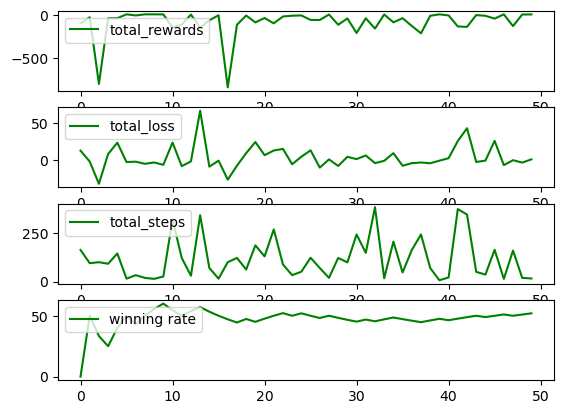

 36%|███▌      | 99/276 [00:19<00:25,  6.84it/s, Game: 100, 9X4, won, steps: 110, dfs_steps: 198, reward: -14, loss 4.676454544067383, Win: 59.0%]    

Episode: 100, Steps: 110, dfs_steps: 198, reward: -14, loss 4.676454544067383


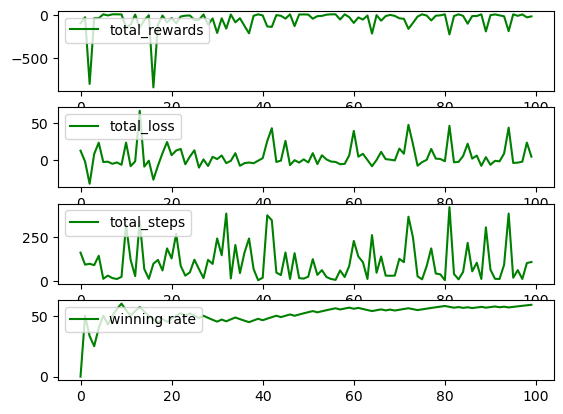

 54%|█████▍    | 149/276 [00:29<00:11, 10.83it/s, Game: 150, 12X2, won, steps: 20, dfs_steps: 37, reward: 9, loss -3.835620403289795, Win: 60.67%]      

Episode: 150, Steps: 20, dfs_steps: 37, reward: 9, loss -3.835620403289795


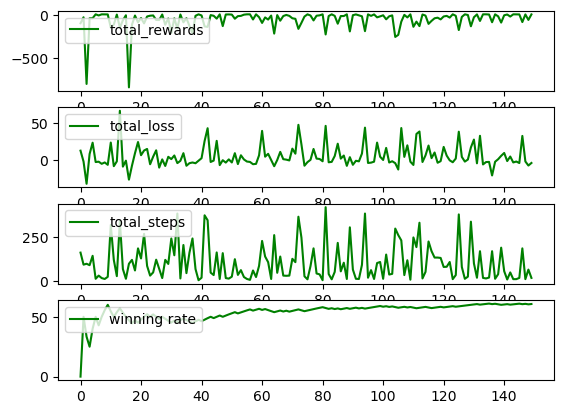

 72%|███████▏  | 199/276 [00:38<00:16,  4.81it/s, Game: 200, 4X5, lost, steps: 15, dfs_steps: 15, reward: -2, loss 1.3027946949005127, Win: 57.0%]        

Episode: 200, Steps: 15, dfs_steps: 15, reward: -2, loss 1.3027946949005127


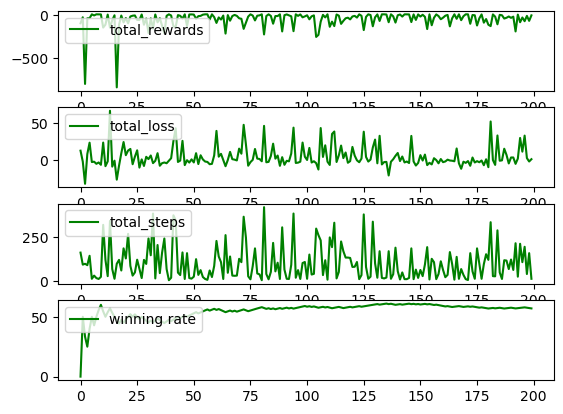

 90%|█████████ | 249/276 [00:45<00:06,  4.47it/s, Game: 250, 6X3, won, steps: 18, dfs_steps: 33, reward: 6, loss 1.8212560415267944, Win: 54.8%]         

Episode: 250, Steps: 18, dfs_steps: 33, reward: 6, loss 1.8212560415267944


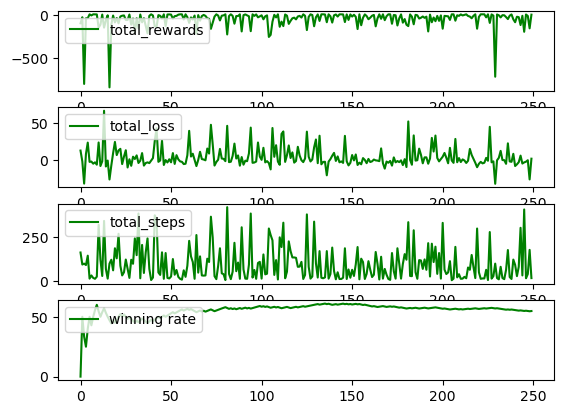

100%|█████████▉| 275/276 [00:52<00:00,  2.66it/s, Game: 276, 10X5, won, steps: 282, dfs_steps: 518, reward: -118, loss 31.5819091796875, Win: 53.62%]    

Episode: 276, Steps: 282, dfs_steps: 518, reward: -118, loss 31.5819091796875


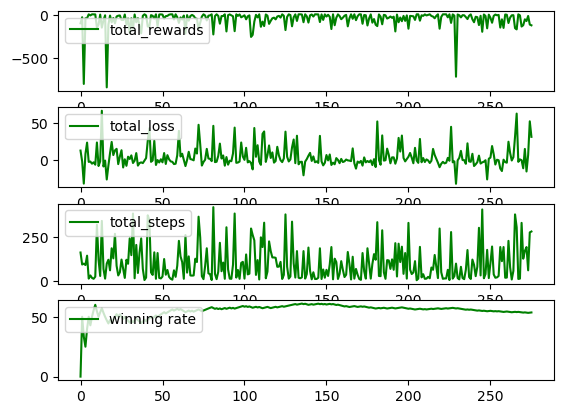

100%|██████████| 276/276 [00:53<00:00,  5.21it/s, Game: 276, 10X5, won, steps: 282, dfs_steps: 518, reward: -118, loss 31.5819091796875, Win: 53.62%]


In [183]:
EPSILON = np.finfo(np.float32).eps.item()
pg = REINFORCEAgent(env, max_color, max_length, max_empty, EPSILON, GAMMA, LR, DEVICE)
pg_train_res = pg.train(EPISODES, plot=True)

In [184]:
print_eval_num(pg_train_res["board_config_wins"])

148 276 {8: 12, 10: 24, 7: 9, 11: 20, 13: 16, 14: 10, 9: 22, 4: 0, 6: 22, 12: 11, 5: 2} {8: 36, 10: 36, 7: 25, 11: 36, 13: 26, 14: 18, 9: 33, 4: 5, 6: 24, 12: 25, 5: 12} {4: 31, 2: 55, 5: 24, 3: 31, 6: 7} {4: 73, 2: 62, 5: 58, 3: 63, 6: 20}
Win: 53.62% (276 games)
Win by number of Tubes (2 empty)
	8: 33.33% (36 games)
	10: 66.67% (36 games)
	7: 36.0% (25 games)
	11: 55.56% (36 games)
	13: 61.54% (26 games)
	14: 55.56% (18 games)
	9: 66.67% (33 games)
	4: 0.0% (5 games)
	6: 91.67% (24 games)
	12: 44.0% (25 games)
	5: 16.67% (12 games)
Win by Length
	4: 42.47% (73 games)
	2: 88.71% (62 games)
	5: 41.38% (58 games)
	3: 49.21% (63 games)
	6: 35.0% (20 games)


In [185]:
pg_val_res = pg.evaluate(Phase.VALIDATION)
print_eval_num(pg_val_res["board_config_wins"])

100%|██████████| 138/138 [00:26<00:00,  5.23it/s]

83 138 {6: 6, 10: 12, 12: 8, 9: 13, 7: 11, 5: 1, 14: 5, 13: 13, 8: 6, 11: 8, 4: 0} {6: 11, 10: 25, 12: 15, 9: 18, 7: 15, 5: 4, 14: 8, 13: 14, 8: 13, 11: 13, 4: 2} {6: 5, 5: 18, 3: 14, 4: 13, 2: 33} {6: 13, 5: 28, 3: 31, 4: 29, 2: 37}
Win: 60.14% (138 games)
Win by number of Tubes (2 empty)
	6: 54.55% (11 games)
	10: 48.0% (25 games)
	12: 53.33% (15 games)
	9: 72.22% (18 games)
	7: 73.33% (15 games)
	5: 25.0% (4 games)
	14: 62.5% (8 games)
	13: 92.86% (14 games)
	8: 46.15% (13 games)
	11: 61.54% (13 games)
	4: 0.0% (2 games)
Win by Length
	6: 38.46% (13 games)
	5: 64.29% (28 games)
	3: 45.16% (31 games)
	4: 44.83% (29 games)
	2: 89.19% (37 games)


In [68]:
# pg.save(pg_train_res["board_config_wins"], pg_val_res["board_config_wins"], f"smart reward 10, {EPISODES} episodes, MLP, no max")

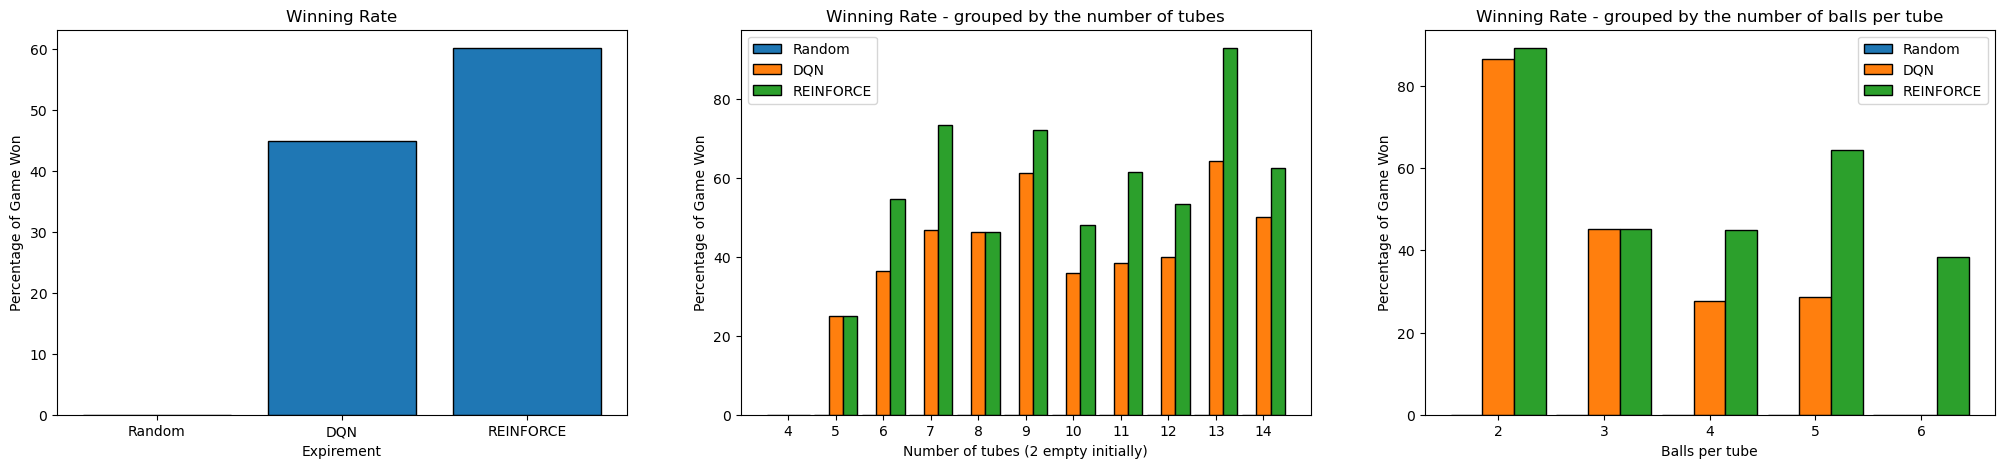

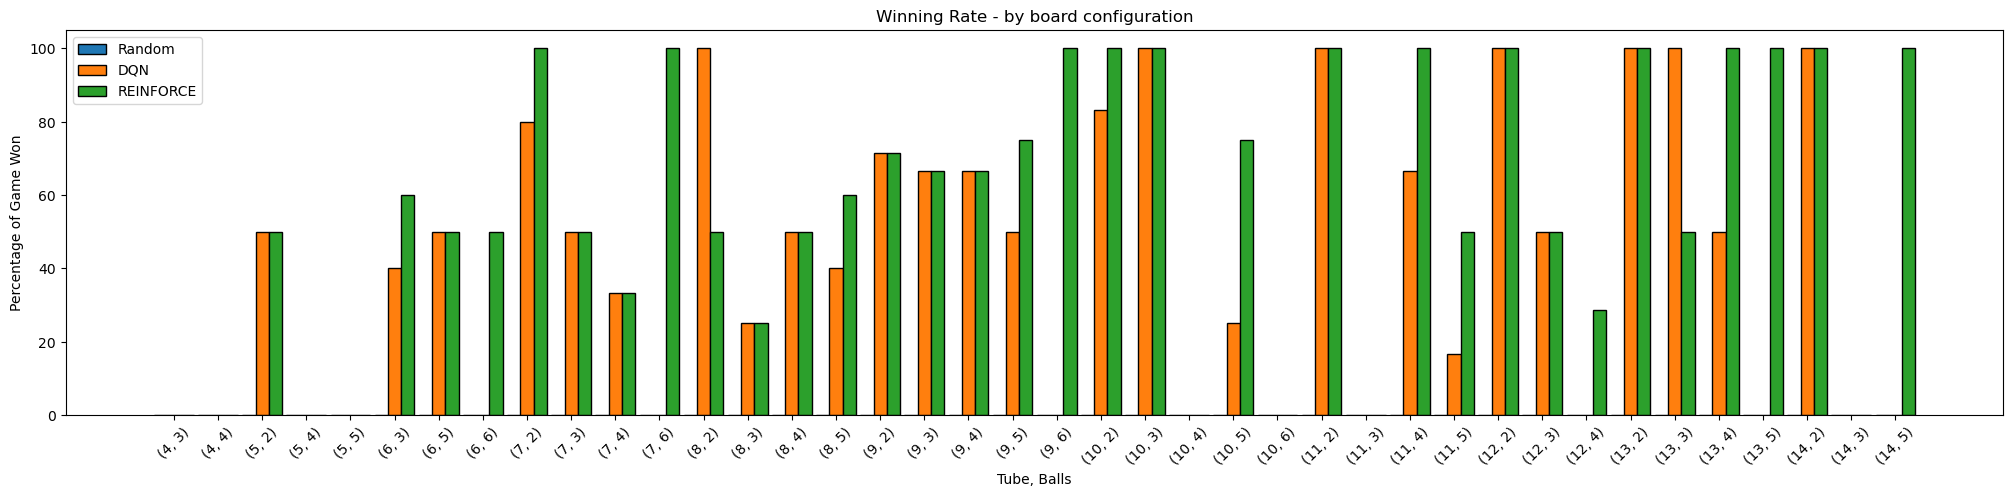

In [191]:
plot_winning({"Random": rand_val_res["board_config_wins"], "DQN": dqn_val_res["board_config_wins"], "REINFORCE": pg_val_res["board_config_wins"]})

In [ ]:
# plot_data_dist(train_data)

In [ ]:
# plot_data_dist(validate_data)

In [ ]:
# rand.eval_one(Phase.VALIDATION, i=15, render=True)

In [193]:
# dqn.eval_one(Phase.VALIDATION, i=15, render=True)

In [ ]:
# pg.eval_one(Phase.VALIDATION, i=15, render=True)